# CMPE 252, Section 01, HW2 - FALL 2023


## Topic: Sequential decision making with discrete state and action spaces.

In this assignment, you will solve MDP by **Value Iteration** and **Policy Iteration**
algorithms with a known dynamics and reward, $T$ and $R$, respectively.

The assignment has 2 parts. In Part-1, you are asked to fill in the blanks in the given code, and to complete the given tasks. In Part-2, you are asked to implement the Policy Iteration algorithm using tensor broadcasting (no for loops).

You can work in teams of 2 students. Please assign yourselves to the pair in Canvas.

You can discuss your solutions with other teams, but sharing your code or parts of it with other teams is plagiarism.

What to submit in Canvas: 1) a working notebook with the full solution, and 2) its corresponding PDF.


Due date : October 10, 2023, 11:59PM



# <h1><center> Part-1 </center></h1>

#### Import the necessary libraries:

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import datetime
import random
%matplotlib inline


<font color='red'>
You can use your maze from HW1. Make sure that there are multiple paths (at least 3) from the START = 'top left corner' to GOAL='bottom right corner'. If you do not have at least 3 paths, update your maze accordingly
</font>

#### Design a maze:

In [56]:
def get_maze(maze_file):
    '''
    para1: filename of the maze txt file
    return mazes as a numpy array walls: 0 - no wall, 1 - wall
    '''
    a = open(maze_file, 'r')
    m=[]
    for i in a.readlines():
        m.append(np.array(i.split(" "), dtype="int32"))
    return np.array(m)

In [57]:
# State Space
S=get_maze("maze_25x25.txt")
START = (1,1)
GOAL = (24,24)
# Action Space
A = [
    (-1, 0),    # 'up'
    (1, 0),     # 'down'
    (0, -1),    # 'left'
    (0, 1),     # 'right'
    (0, 0)      # 'stay'
]


# Noise
ALPHA = [0.2, 0.8]

max_it = 100

In [58]:
GRID_SIZE = len(S)
# goal state
S[GOAL] = 3

#### Visualize the maze:

In [59]:
print(S)

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1]
 [1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1]
 [1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1]
 [1 0 1 0 1 0 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1]
 [1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 1]
 [1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1]
 [1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1]
 [1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 0 0 1 0 1 1 1]
 [1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1]
 [1 1 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1]
 [1 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1 0 1 0 0 0 1]
 [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1]
 [1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1]
 [1 0 1 0 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1]
 [1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1]
 [1 0 1 0 0 0 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 1 0 1]
 [1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1]
 [1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 1 1 1 1 

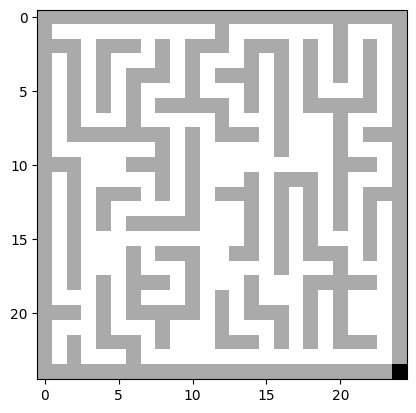

In [60]:
plt.imshow(S, cmap='binary')

#### Define a utility function, s_next_calc, which computes the index of the next state given current state and action:

In [61]:
def s_next_calc(s, a):
    '''This function returns the agent's next state given action
    and current state (assuming the action succeeds).
    : param s: Current position of the agent
    : param a: action taken by the agent
    : returns: New state coordinates in the grid
    '''

    return (s[0] + A[a][0], s[1] + A[a][1])

#### Define a utility function to check if the action at current state leads to a collision with a wall:

In [62]:
def hit_wall(curr, action):
    '''This function checks if the agent hits any walls.
    : param curr: Current position of the agent
    : param action: Chosen action by the agent
    : returns: True/False Binary value to indicate if agent hits a wall
    '''
    s_new = (
        curr[0] + A[action][0],
        curr[1] + A[action][1]
    )

    # Check for grid boundaries
    if min(s_new) < 0 or max(s_new) > GRID_SIZE-1:
        return True

    # Check walls
    # 0: 'up':   (-1,  0),
    # 1: 'down': ( 1,  0),
    # 2: 'left': ( 0, -1),
    # 3: 'right':( 0,  1),
    # 4: 'stay': ( 0,  0)
    if (S[curr]==0 and S[s_new]==1):
        return True

    return False

#### Define the reward function:

In [63]:
def R(s, a):
    '''Reward function
    : param s: Current state of the agent
    : param a: Action the agent takes at the current state
    : returns: Reward for the action at current state
    '''
    if s == GOAL:
        return 0
    elif hit_wall(s, a):
        return -10000
    else:
        return -1

#### Calculate the transition probabilities to state s_next from current state s upon action a:

In [64]:
def Pr(s_next, s, a, alpha):
    '''This function returns probabilities for each action at agent's
    current state.
    :param s: Current state of the agent
    :param a: Action the agent takes at the current state
    :param alpha: Probability of the agent to take a random action instead of the action a
    :returns : Transition probability for the action at current state
    '''
    # can't move once reached the GOAL
    if s == GOAL:
        if s_next == s:
            return 1
        else:
            return 0

    # If wall hit, next state is current state
    if hit_wall(s, a):
        # Illegal action with s = s'
        if s_next == s:
            return 1
        # Illegal action with s != s'
        else:
            return 0

    # Legal action with adjacent s and s'
    if s_next == s_next_calc(s, a):
        return 1 - alpha
    else:
        # Agent moves to another adjacent state instead of s' due to noise in a
        # Generate all other neighbors of s by applying actions other than a
        other_s_next = [s_next_calc(s, i)
                    for i in range(len(A)) if i != a]
        if s_next in other_s_next:
            return alpha/4
    return 0

## Policy Iteration

In policy iteration, we define three functions:

* policy_evaluation
* policy_improvement
* policy_iteration

Refer to the lecture slides on policy iteration and value iteration.

In [65]:
def policy_evaluation(policy, S, Pr, alpha, discount, theta, ctr):

    V = np.zeros((GRID_SIZE, GRID_SIZE))
    V_prev = np.zeros((GRID_SIZE, GRID_SIZE))

    for _ in range(ctr):
        # chose an initial delta value for the convergence test
        #delta = '???'
        delta = 0
        V_prev = V.copy()
        for s, _ in np.ndenumerate(S):

            # action by the policy
            #a = '???'
            a = policy[s]
            # update value function for the state s
#             V[s] = '???'
            V[s] = sum(
                Pr(s_next, s, a, alpha) * (R(s, a) + discount * V[s_next])
                for s_next in itertools.product(range(GRID_SIZE), repeat=2)
            )
            # convergece test
            delta = max(delta, abs(V[s] - V_prev[s]))

        if delta < theta: break

    return V, delta

In [66]:
def policy_improvement(V, S, A, Pr, alpha, discount):

    policy = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
    policy_stable = True

    for s, _ in np.ndenumerate(S):

        old_action = policy[s]
        Q = np.zeros(len(A))
        for a in range(len(A)):
            # update Q function at state, s, and action, a
            # Q[a] = '???'
            for i_prime in range(GRID_SIZE):
                for j_prime in range(GRID_SIZE):
                    s_prime = (i_prime, j_prime)
                    r = R(s, a)
                    Q[a] += Pr(s_prime, s, a, alpha) * (r + discount * V[s_prime])

            # update policy at state s
            # policy[s] = '???'
            policy[s] = np.argmax(Q)

        if old_action != policy[s]: policy_stable = False

    return policy, policy_stable

In [67]:
def policy_iteration(S, A, Pr, alpha, discount, theta, n_eval, plot_enable, plot=None):
    """
    :param list S: set of states
    :param list A: set of actions
    :param function Pr: transition function
    :param float alpha: noise
    :param float discount: discount factor
    :param float theta: tolerance, which determines when to end iterations
    :param int n_eval: number of evaluations
    :param plot: list of iteration numbers to plot
    """

    epsilon = 0

    # For Task 4 ######
    start_time = 0
    end_time = 0
    time = 0
    total_time = 0
    ###################

    plt.ion()
    policy = np.random.randint(0, len(A), (GRID_SIZE, GRID_SIZE))
    count=0

    while True:

        start_time = datetime.datetime.now() # For Task 4

        V, delta = policy_evaluation(policy, S, Pr, alpha, discount, theta, n_eval)
        policy , policy_stable = policy_improvement(V, S, A, Pr, alpha, discount)


        # For Task 4
        end_time = datetime.datetime.now()
        time = (end_time - start_time).total_seconds() # calculate time taken [seconds] for one iteration
        total_time += time


        # plot intermediate result
        if (plot and count+1 in plot) and plot_enable:
            plot_value_grid(V, policy, msg='Policy iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))

        if delta == 0:
            if plot_enable :
                plot_value_grid(V, policy, msg='Policy iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            break

        if (delta > 0 and delta<=epsilon) or count==max_it or policy_stable:
            if(count == max_it):
                print('Policy iteration failed to converge for alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            if(plot_enable):
                 plot_value_grid(V, policy, msg='Policy iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            break
        count=count+1

    return V, policy, count, total_time


## Value Iteration

We use the following function for value iteration. See slides starting from 61.

In [68]:
def value_iteration(S, A, Pr, alpha, discount, plot_enable, plot=None):
    """
    :param list S: set of states
    :param list A: set of actions
    :param function Pr: transition function
    :param float alpha: noise
    :param float discount: discount factor
    """
    # For Task 4 ######
    start_time = 0
    end_time = 0
    time = 0
    total_time = 0
    ###################

    plt.ion()

    V = np.zeros((GRID_SIZE, GRID_SIZE))
    V_prev = np.zeros((GRID_SIZE, GRID_SIZE))
    optimal_policy = np.random.randint(0, len(A), (GRID_SIZE, GRID_SIZE), dtype=int)

    count=0
    while True:

        start_time = datetime.datetime.now() # For Task 4

        delta = 0
        V_prev = V.copy()

        for s,_ in np.ndenumerate(S):

            Q = np.zeros(len(A))
            for a in range(len(A)):
            # Q[a] = '???'  # expression for the Q function at state, s, and action, a
                Q[a] = sum(
                Pr(s_prime, s, a, alpha) * (R(s, a) + discount * V_prev[s_prime])
                for s_prime in itertools.product(range(GRID_SIZE), repeat=2)
            )
            # V[s] = '???'
                V[s] = np.max(Q)
            # delta = max(delta, '???') # set the validation condition for the convergence
                delta = max(delta, abs(V[s] - V_prev[s]))
            #print(delta)

            optimal_policy[s] = np.argmax(Q)

        # For Task 4
        end_time = datetime.datetime.now()
        time = (end_time - start_time).total_seconds() # calculate time taken [seconds] for one iteration
        total_time += time


        # plot current value and optimal policy
        if (plot and count+1 in plot) and plot_enable:
            plot_value_grid(V, optimal_policy, msg='Value iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            plt.pause(0.1)
        if delta <= 0 or count==max_it:
            if count == max_it:
                print('Value iteration failed to converge for alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            if(plot_enable):
                plot_value_grid(V, optimal_policy, msg='Value iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
                plt.pause(0.1)
            break
        count=count+1
    return V, optimal_policy, count, total_time


#### We will use the following utility function to plot the grid with values from V:

In [69]:
def plot_value_grid(V, policy, msg=""):
    fig = plt.figure(figsize=(5, 5), tight_layout=True)
    plt.title(msg)
    plt.imshow(V)

    quiver_action_dict = [
            [1, 0],
            [-1, 0],
            [0, -1],
            [0, 1],
            [0, 0]
    ]
    for k, a in np.ndenumerate(policy):
        if(S[k] == 0): # do not print the arrows on walls, to increase readibility
            q = plt.quiver(k[1], k[0], quiver_action_dict[a][1], quiver_action_dict[a][0])
    #fig.colorbar(q)
    plt.show()

## Tasks
### A. Find the optimal solution by two methods for  $\alpha$ = 0 (no noise).

### I. Policy Iteration

We are using iterative policy evaluation.

In [70]:
n_pol_eval = 100 #number of policy evalutions
val2, pol2, pol_max_iter, time_taken = policy_iteration(S, A, Pr, alpha=0, discount=1, theta = 1e-6, n_eval=n_pol_eval, plot_enable = True)


KeyboardInterrupt: ignored

### II. Value Iteration

Run for 100 iterations.
Plot the value function and the optimal policy, at iterations 1, 25, 50, 100.

In [ ]:
val1, pol1, val_max_iter, time_taken = value_iteration(S, A, Pr, alpha=0, discount=1, plot_enable=True, plot=[1, 25, 50, 100])


Let's visualize these results

In [ ]:
# Plot for policy iteration alpha = 0, k_max = 100, run for 100 iterations
plot_value_grid(val2, pol2, msg='Policy Iteration, {} iterations, {} evaluations'.format(pol_max_iter, n_pol_eval))
# Plot for value iteration alpha = 0, 100 iterations
plot_value_grid(val1, pol1, msg='Value Iteration, {} iterations'.format(val_max_iter))

### III. Run Policy Iteration and Value Iteration for  five different discounted factors $\gamma \in \{0, 0.1, 0.4, 0.9, 1\}$ and perform the following tasks

1. Explain the change in utilities for different $\gamma$
2. Explain the change in optimal policies for different $\gamma$

#### Policy iteration for 𝛾∈{0,0.1,0.4,0.9,1} :

In [ ]:
n_pol_eval = 100 #number of policy evalutions
pol_time_list = []
for gamma in [0,0.1,0.4,0.9,1] :
    val2, pol2, pol_max_iter, comp_time = policy_iteration(S, A, Pr, alpha=0, discount=gamma, theta=1e-6, n_eval=n_pol_eval, plot_enable = True)
    pol_time_list.append(comp_time)
    plt.pause(0.1)

#### Value iteration for 𝛾∈{0,0.1,0.4,0.9,1} :

In [ ]:
n_pol_eval = 100 #number of policy evalutions
val_time_list = []
for gamma in [0,0.1,0.4,0.9,1] :
    val1, pol1, val_max_iter, comp_time = value_iteration(S, A, Pr, alpha=0, discount=gamma, plot_enable=True, plot=None)
    val_time_list.append(comp_time)
    plt.pause(0.1)

#### Your explanations:

### IV. Plot $\gamma$ VS computational time for the given $\gamma$ 's in Task 3:

#### 𝛾 VS computational time for Policy iteration :

In [ ]:
fig = plt.figure(figsize=(15,5))

plt.xlabel('Discount')
plt.ylabel('Computational time [sec]')
plt.plot([0,0.1,0.4,0.9,1], pol_time_list)
plt.title('Discount VS Computational time for Policy iteration')

#### 𝛾 VS computational time for Value iteration :

In [ ]:
fig = plt.figure(figsize=(15,5))

plt.xlabel('Discount')
plt.ylabel('Computational time [sec]')
plt.plot([0,0.1,0.4,0.9,1], val_time_list)
plt.title('Discount VS Computational time for Value iteration')

### B. Repeat Value and Policy iteration for 10, 20 and 100 iterations with $\alpha \in \{0.2, 0.8\}$

#### I. Policy Iteration

In [ ]:
for idx1, alpha in enumerate(ALPHA):
    val, pol, pol_iter, time_taken = policy_iteration(S, A, Pr, alpha=alpha, discount = 1, theta=1e-6, n_eval=100, plot_enable = True, plot=[10, 20, 100])


#### II. Value Iteration

In [ ]:
for idx1, alpha in enumerate(ALPHA):
    val, pol, val_iter, comp_time = value_iteration(S, A, Pr, alpha = alpha, discount = 1, plot_enable=True, plot=[10, 20, 100])


**Summarize insights and your observations in Question B-I and B-II**

### C. Explain (up to 5 sentences) the differences between the approaches in HW1 (search, A*) and the approaches in the current assignment (MDP/Value/Policy)

## <h1><center> Part-2 </center></h1>

#### <h1><center> Utility functions to be implemented / PSEUDOCODE </center></h1>

Action space: Same as Part-1.
<br>
State space: Design a 10x10 maze with 3 obstacles (an obstacle is a fence with a few blocks of "wall"). You can use the get_maze() function from Part-1.
<br><br>
dS - size of the maze with dimensions: dS x dS
<br>
dA - number of actions
<br>
Goal - goal state.
<br><br>

PSEUDOCODE: function validState(s) =  returns true if (state, s, is within the maze boundaries) AND (s is NOT in the obstacles)

PSEUDOCODE: function BuildMaze(dS, dA, Goal):
<br>

	# dynamics tensor with dimensions: |dS| x |dS| x |dA| x |dS| x |dS| x 1, where the
	# dimensions are S₁, S₂, A, S₁′, S₂′. e.g., S₂ is the current second coordinate of the state, and S₁′ is the first coordinate of the state at the next time step.
	Ps′_sa = zeros(dS, dS, dA, dS, dS)

	# the reward tensor with the same dimension as the dynamics
	# reward is 0 at the Goal state, -10000 if agent hits the wall, and -1 elsewhere.
	Rs′sa  = -ones(dS, dS, dA, dS, dS)

	# iterate over the valid states
	for s in filter(validState, (x->x.I).(CartesianIndices((dS, dS))))
		if s ∈ Goal
			Ps′_sa[s..., :, s...] .= 1.0 # all the actions get prob 1 at the goal
			Rs′sa[s..., :, s...]  .= 0.0 # all the actions get reward 0
			continue
		end

		for a in Actions # the same action set at each state
			# if "next state is valid" move to it, otherwise stay at place
			s′ = validState(s .+ a[2]) ? s .+ a[2] : s
			Ps′_sa[s..., a[1], s′...] = 1.0
		end
	end
	"sanity test:" forall a, s : sum_s′ Ps′_sa = 1
	return Ps′_sa, Rs′sa
end


#### <h1><center> TASKS </center></h1>

### Placeholder for the definition of global variables, functions, etc

### Task 1 ###
Build your maze with dimensions 10x10 and 3 fences, and the goal state (exit)
in one of the corners of the maze. Visualize the maze layout on 2D plot.

### Task 2 ###
Implement the Policy Evaluation (PE) algorithm for a deterministic policy, π.
<br>
The dimensions of the policy π[a | s] are |dS| x |dS| x |dA| x 1 x 1 x 1.
<br>
There is a single possible action at every state.
<br>
E.g., π[UP | some_state] = [1, 0, 0, 0, 0], see 'Actions' above.
<br>
E.g., π[Stay | another_state] = [0, 0, 0, 0, 1], see 'Actions' above.
<br><br>
Evaluate a random deterministic policy, π.  Plot Value of a random policy on 2D plot.
<br><br>
Instructions:
<br>
The policy is stationary, which means π[a′ | s′] is permute_dimensions(π[a | s], dim1->dim4, dim2->dim5, dim3->dim6)
<br>
Use broadcasting '.*', e.g.,
<br>
p(s′ a′ | s, a) = π[a′|s′] .* p(s′ | s, a)
<br>
sum_s′p(s′ | s, π[a|s]) .* V[s′], where V[s′] is the value of the next state with dimensions 1 x 1 x 1 x dS x dS x 1.
<br>
The value of the current state has dimensions dS x dS x 1 x 1 x 1 x 1.
"V of the next state" is permute_dimensions("V of the current state", dims1->dims4, dims2->dims5)

### Task 3 ###
Repeat Task 2 with manually setting the optimal actions in the radius of 2 states from the goal state.
Explain your observations.

#### Your observations:

### Task 4 ###
Implement the Policy Improvement (PI) Algorithm, and find the optimal policy π*.
Visualize the optimal value function, V_i, on a 2D plot at 3 different iterations, i, of PI.
Explain your observations.

#### Your observations: